In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Milestone stuff

In [3]:
filepath = 'SPY.csv'
raw_df = pd.read_csv(filepath)

# Final messing around

In [196]:
raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,148.25000,148.25000,143.875000,145.4375,97.825676,8164300
1,2000-01-04,143.53125,144.06250,139.640625,139.7500,94.000107,8089800
2,2000-01-05,139.93750,141.53125,137.250000,140.0000,94.168259,12177900
3,2000-01-06,139.62500,141.50000,137.750000,137.7500,92.654861,6227200
4,2000-01-07,140.31250,145.75000,140.062500,145.7500,98.035896,8066500


In [197]:
# raw_df.truncate(before=len(raw_df)/2).head()

,Date,Open,High,Low,Close,Adj Close,Volume
2641,2010-07-06,103.639999,104.370003,101.879997,102.870003,83.143509,256935300
2642,2010-07-07,103.129997,106.239998,103.019997,106.110001,85.762192,253769400
2643,2010-07-08,107.000000,107.279999,105.910004,107.160004,86.610847,210842100
2644,2010-07-09,107.129997,107.970001,106.930000,107.959999,87.257454,144999900
2645,2010-07-12,107.599998,108.239998,107.150002,108.029999,87.314003,131283600


In [5]:
# change timestamp to num days from beginning of data
series_df = raw_df.copy()
series_df['Date'] = pd.to_datetime(series_df['Date'])
series_df['Date'] = series_df['Date'].astype('int64')
series_df['Date'] = (series_df['Date'] - series_df.iloc[0, 0]) / 86400000000000
series_df['Date'] = series_df['Date'].astype('int64')
series_df = series_df.truncate(before=len(series_df)/2)

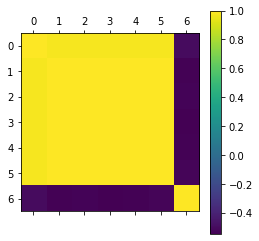

In [6]:
corr_df = series_df - series_df.mean()
corr_df = corr_df / corr_df.std()
plt.matshow(corr_df.corr())
plt.colorbar()
plt.show()

In [7]:
series_df = series_df.drop(columns=['Date', 'Open', 'High', 'Low', 'Adj Close'])
series_df.head()

,Close,Volume
2641,102.870003,256935300
2642,106.110001,253769400
2643,107.160004,210842100
2644,107.959999,144999900
2645,108.029999,131283600


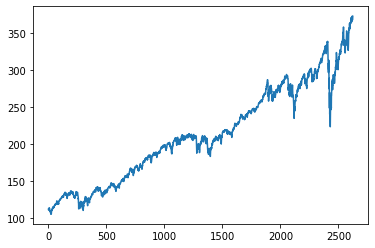

In [178]:
window = 10
temp = [(np.array(series_df.iloc[i:i+window, 0]), np.array(series_df.iloc[i+window+5, 0])) 
          for i in range(len(series_df) // window * window - window - 5)]
X, y = zip(*temp)
X, y = np.array(X), np.array(y)

plt.plot(y)
# X_train, X_test, y_train, y_test = train_test_split(X, y)

In [211]:
train_size = int(0.8 * len(X))
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [212]:
scaler = StandardScaler()
scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [213]:
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = X_train_scaled.reshape(-1, 10)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled.reshape(-1, 10)

In [218]:
X_test_scaled[:10]

array([[1.69986166, 1.73471589, 1.85338312, 1.84310786, 1.78790477,
        1.68334081, 1.67306556, 1.63559207, 1.69240668, 1.70671162],
       [1.73471589, 1.85338312, 1.84310786, 1.78790477, 1.68334081,
        1.67306556, 1.63559207, 1.69240668, 1.70671162, 1.61343005],
       [1.85338312, 1.84310786, 1.78790477, 1.68334081, 1.67306556,
        1.63559207, 1.69240668, 1.70671162, 1.61343005, 1.51309684],
       [1.84310786, 1.78790477, 1.68334081, 1.67306556, 1.63559207,
        1.69240668, 1.70671162, 1.61343005, 1.51309684, 1.53122918],
       [1.78790477, 1.68334081, 1.67306556, 1.63559207, 1.69240668,
        1.70671162, 1.61343005, 1.51309684, 1.53122918, 1.49556888],
       [1.68334081, 1.67306556, 1.63559207, 1.69240668, 1.70671162,
        1.61343005, 1.51309684, 1.53122918, 1.49556888, 1.58119443],
       [1.67306556, 1.63559207, 1.69240668, 1.70671162, 1.61343005,
        1.51309684, 1.53122918, 1.49556888, 1.58119443, 1.59932677],
       [1.63559207, 1.69240668, 1.7067116

In [219]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape + (1,))
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape + (1,))
y_train = y_train.reshape((len(y_train), 1))
y_test = y_test.reshape((len(y_test), 1))

In [183]:
def root_mean_squared_error(y_true, y_pred):
        return backend.sqrt(backend.mean(backend.square(y_pred - y_true))) 

In [224]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(20, activation='relu', dropout=0.2, return_sequences=True, input_shape=(window, 1), name='lstm1'))
model.add(tf.keras.layers.LSTM(20, activation='relu', dropout=0.2, name='lstm2'))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu, name='dense1'))

adam = tf.keras.optimizers.Adam()

model.compile(optimizer=adam, loss="mean_squared_error")

history = model.fit(X_train_scaled, y_train, epochs=30, validation_split=0.125, shuffle=False)
model.summary()

Epoch 1/30
58/58 [==============================] - 3s 17ms/step - loss: 22100.5713 - val_loss: 68128.9141
Epoch 2/30
58/58 [==============================] - 1s 10ms/step - loss: 8845.4705 - val_loss: 16025.8535
Epoch 3/30
58/58 [==============================] - 1s 11ms/step - loss: 192540.0935 - val_loss: 53252.9883
Epoch 4/30
58/58 [==============================] - 1s 11ms/step - loss: 12314.3150 - val_loss: 32310.0449
Epoch 5/30
58/58 [==============================] - 1s 11ms/step - loss: 8374.3769 - val_loss: 47620.9062
Epoch 6/30
58/58 [==============================] - 1s 11ms/step - loss: 12297.7367 - val_loss: 23150.5352
Epoch 7/30
58/58 [==============================] - 1s 11ms/step - loss: 8670.1236 - val_loss: 40197.1875
Epoch 8/30
58/58 [==============================] - 1s 12ms/step - loss: 8618.7932 - val_loss: 25745.0957
Epoch 9/30
58/58 [==============================] - 1s 11ms/step - loss: 8043.7035 - val_loss: 27917.3066
Epoch 10/30
58/58 [======================

<function matplotlib.pyplot.show>

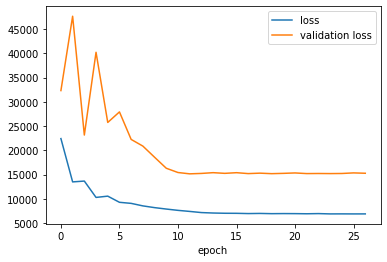

In [225]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss[3:], label='loss')
plt.plot(val_loss[3:], label='validation loss')
plt.xlabel('epoch')
plt.legend()
plt.show

In [226]:
model.evaluate(X_test_scaled, y_test, return_dict=True)

17/17 [==============================] - 0s 3ms/step - loss: 19382.8555


{'loss': 19382.85546875}

(525, 5)


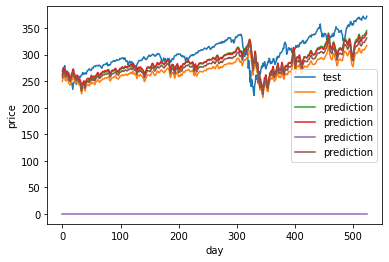

In [227]:
y_pred = model.predict(X_test_scaled)
print(y_pred.shape)
l = len(y_pred)
plt.plot(y_test, label='test')
plt.plot(y_pred, label='prediction')
plt.ylabel('price')
plt.xlabel('day')
plt.legend()

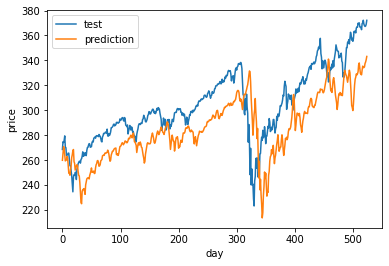

In [194]:
plt.plot(y_test, label='test')
plt.plot(y_pred, label='prediction')
plt.ylabel('price')
plt.xlabel('day')
plt.legend()

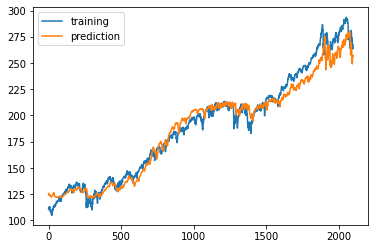

In [195]:
y_pred = model.predict(X_train_scaled)
l = len(y_pred)
plt.plot(y_train, label='training')
plt.plot(y_pred, label='prediction')
plt.legend()